In [1]:
%matplotlib notebook

The goal of this notebook is a figure showing the before and after stimulus similar to Figure 6E in the original Tastekin et al., 2018 paper.

For this script to work you need to get the relevant tiff file. It is not provided in this repository as the file is >300 Mb large. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
from pathlib import Path
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import os

In [3]:
# This file is not provided in the repository as it is way too large
# The script will therefore not work unless correct path to the file is provided
filepath = Path('I:\\My Drive\\PhD\\Papers\\ATR control paper\\Figure 1\\data\\210409 - MS571xFDT355_ATR+\\animal 1\\2021-04-09_18-38-08_2V_2s_step')

In [4]:
home_path = os.getcwd()

savepath = Path(home_path, 'plots')

Path(savepath).mkdir(parents=True, exist_ok=True) 

In [5]:
# Load the stimulus files
stim = np.load(Path(filepath, '2V_2s_step.npy'))
# Load the image file
vol=ScanImageTiffReader(str(Path(filepath, 'MS571xFDT355_ATR+_00029.tif')))
# Extract the image data from the tif file
image_stack = vol.data()
# Extract metadata (as of yet not well formatted, see below) from the tif file
metadata = vol.metadata()

In [6]:
# properly format this relatively complex metadata
clean_metadata = {}
for i in range(len(vol.metadata().split("\n"))):
    try:
        clean_metadata[vol.metadata().split("\n")[i].split(" =")[0]] = \
            vol.metadata().split("\n")[i].split("= ")[1]
    except IndexError:
        pass
actual_framerate = float(clean_metadata['SI.hRoiManager.scanFrameRate'])
# The extraction of the pixel/um is a bit of a pain
# extract total image FOV
imFOV = clean_metadata['SI.hRoiManager.imagingFovUm']
# return: '[-15.9545 -15.9545;15.9545 -15.9545;15.9545 15.9545;-15.9545 15.9545]'
# This seems to be the space recorded in um from the center? Might change if the FOV is not a square
# I take the first and the last value and look at the total distance
# THIS MIGHT NOT WORK FOR OTHER IMAGES - ALWAYS DOUBLE CHECK THE  OUTPUT OF im_FOV
# ALSO NOT SURE ABOUT WHICH NUMBER IS X AND WHICH IS Y!
# Also check this repository: # https://github.com/raacampbell/measurePSF/blob/master/code/%2Bsibridge/getFOV.m#L3
image_in_um = abs(float(imFOV.split(' ')[0].split('[')[-1])) + float(imFOV.split(' ')[-1].split(']')[0])
# Grab number of pixels in each dimension
x_res = int(clean_metadata['SI.hRoiManager.linesPerFrame'])
y_res = int(clean_metadata['SI.hRoiManager.pixelsPerLine'])
pixel_per_um = x_res/image_in_um

def return_stim_time_index(real_frame_number):
    """
    Recorded images and stimulus index have different times. This function
    helps to reconcile the two.
    
    Input the real frame number and get the closest time in stimulus time.
    """
    
    return(int(round((1000/actual_framerate) * real_frame_number)))

def return_real_frame_index(stim_index_number):
    """
    Recorded images and stimulus index have different times. This function
    helps to reconcile the two.
    
    Input the stim index number and returns the closest frame number.    
    """
    
    return(int(round(actual_framerate/1000 * stim_index_number)))

In [7]:
stim_start = np.where(stim>0)[0][0]
stim_stop = np.where(stim>0)[0][-1]

In [8]:
xlim = (100,500)
ylim = (240,400)

# "before" is 2 seconds before the stimulus starts (2000 stands for 2000 milliseconds)
before = np.mean(image_stack[return_real_frame_index(stim_start-2000):return_real_frame_index(stim_start),
                              ylim[0]:ylim[1], 
                              xlim[0]:xlim[1]],axis=(0))
# "after" is at the last frame where the stimulus is still present/the first frame when the stimulus ends.
after = np.mean(image_stack[return_real_frame_index(stim_start):return_real_frame_index(stim_stop),
                              ylim[0]:ylim[1], 
                              xlim[0]:xlim[1]],axis=(0))

<IPython.core.display.Javascript object>


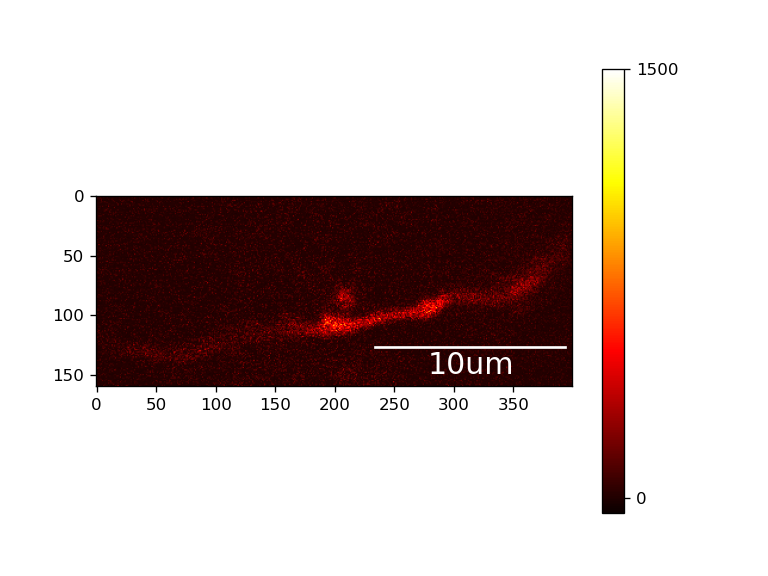

<IPython.core.display.Javascript object>

In [9]:
vmin = -50
vmax = 1500 # manually defining the vmin and vmax leads to nicer image


fig = plt.figure('Before stimulation')
ax1 = fig.add_subplot(111)

fig2 = plt.figure('During stimulation')
ax2 = fig2.add_subplot(111)
ax1.imshow(before, vmin=vmin, vmax=vmax, cmap='hot')
for_colorbar = ax2.imshow(after, vmin=vmin, vmax=vmax, cmap='hot')

#ax1.set_xlim(xlim)
#ax2.set_ylim(ylim)
cbar=fig.colorbar(for_colorbar, 
                  ticks=[0,np.amax(vmax)], 
                  #cax=cax,
                  #fraction=0.046,
                  #pad=0.04
                 )

cbar=fig2.colorbar(for_colorbar, 
                  ticks=[0,np.amax(vmax)], 
                  #cax=cax,
                  #fraction=0.046,
                  #pad=0.04
                 )

# Add a scalebar:
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax1.transData,
                           10 * pixel_per_um, '10um',
                           'lower right',
                           pad=0.1,
                           color='w',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)
ax1.add_artist(scalebar)



fig.savefig(Path(savepath, 'before_stim.svg'))
fig2.savefig(Path(savepath, 'during_stim.svg'))